#Import dataset from drive (Zip File)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!unzip gdrive/My\ Drive/Frood_Drive/D_16.zip

Archive:  gdrive/My Drive/Frood_Drive/D_16.zip
replace D_16/Fresh Apple/rotated_by_15_Screen Shot 2018-06-08 at 4.59.36 PM.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

#Main process

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/D_16',
    color_mode='rgb',
    label_mode = 'categorical',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training',
)
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/D_16',
    color_mode='rgb',
    label_mode = 'categorical',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation',
)

Found 27937 files belonging to 16 classes.
Using 22350 files for training.
Found 27937 files belonging to 16 classes.
Using 5587 files for validation.


In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 2)
validation_dataset = validation_dataset.skip(val_batches // 2)

In [6]:
class_names = train_dataset.class_names

print('Number of training batches: %d' % tf.data.experimental.cardinality(train_dataset).numpy())
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset).numpy())
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset).numpy())

Number of training batches: 699
Number of validation batches: 88
Number of test batches: 87


In [7]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [8]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

IMG_SHAPE = (224,224) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [9]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
base_model.trainable = False

In [10]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

In [11]:
prediction_layer = tf.keras.layers.Dense(16, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)

In [12]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [13]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [14]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

88/88 [==============================] - 12s 62ms/step - loss: 3.1920 - accuracy: 0.0574
initial loss: 3.19
initial accuracy: 0.06


In [15]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
699/699 [==============================] - 55s 75ms/step - loss: 1.1020 - accuracy: 0.6790 - val_loss: 0.3946 - val_accuracy: 0.9187
Epoch 2/10
699/699 [==============================] - 55s 78ms/step - loss: 0.3232 - accuracy: 0.9180 - val_loss: 0.2145 - val_accuracy: 0.9579
Epoch 3/10
699/699 [==============================] - 52s 75ms/step - loss: 0.2053 - accuracy: 0.9489 - val_loss: 0.1503 - val_accuracy: 0.9661
Epoch 4/10
699/699 [==============================] - 52s 74ms/step - loss: 0.1540 - accuracy: 0.9609 - val_loss: 0.1190 - val_accuracy: 0.9732
Epoch 5/10
699/699 [==============================] - 54s 77ms/step - loss: 0.1228 - accuracy: 0.9697 - val_loss: 0.0967 - val_accuracy: 0.9782
Epoch 6/10
699/699 [==============================] - 53s 75ms/step - loss: 0.1027 - accuracy: 0.9750 - val_loss: 0.0831 - val_accuracy: 0.9804
Epoch 7/10
699/699 [==============================] - 53s 76ms/step - loss: 0.0888 - accuracy: 0.9782 - val_loss: 0.0729 - val_accuracy:

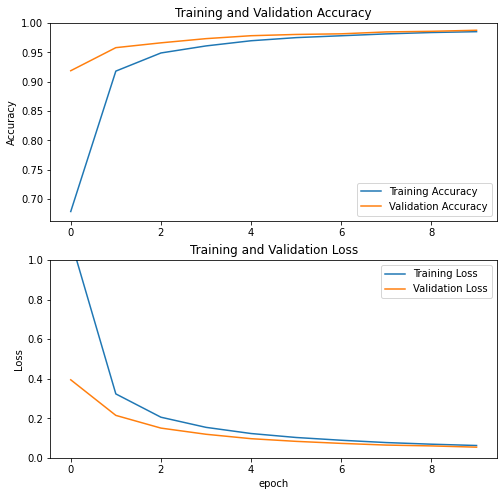

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine tuning for better result

In [17]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [18]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [20]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/15
699/699 [==============================] - 62s 82ms/step - loss: 0.0451 - accuracy: 0.9850 - val_loss: 0.0258 - val_accuracy: 0.9925
Epoch 11/15
699/699 [==============================] - 59s 83ms/step - loss: 0.0202 - accuracy: 0.9936 - val_loss: 0.0204 - val_accuracy: 0.9932
Epoch 12/15
699/699 [==============================] - 64s 91ms/step - loss: 0.0121 - accuracy: 0.9966 - val_loss: 0.0102 - val_accuracy: 0.9961
Epoch 13/15
699/699 [==============================] - 58s 82ms/step - loss: 0.0064 - accuracy: 0.9986 - val_loss: 0.0070 - val_accuracy: 0.9979
Epoch 14/15
699/699 [==============================] - 58s 82ms/step - loss: 0.0051 - accuracy: 0.9985 - val_loss: 0.0078 - val_accuracy: 0.9975
Epoch 15/15
699/699 [==============================] - 58s 83ms/step - loss: 0.0047 - accuracy: 0.9985 - val_loss: 0.0125 - val_accuracy: 0.9957


In [21]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

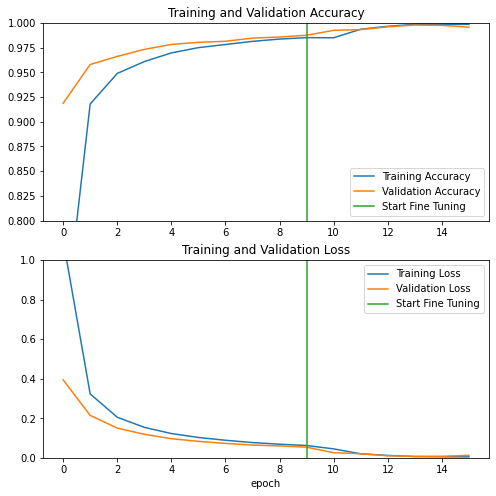

In [22]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Test Model Performance with test set

In [23]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

87/87 [==============================] - 6s 60ms/step - loss: 0.0176 - accuracy: 0.9960
Test accuracy : 0.9960488677024841


Predictions:
 [9, 13, 10, 9, 0, 14, 15, 15, 12, 12, 7, 3, 12, 15, 12, 13, 14, 1, 14, 12, 15, 15, 3, 2, 10, 13, 7, 14, 4, 9, 15, 3]
Labels:
 [9, 13, 10, 9, 0, 14, 15, 15, 12, 12, 7, 3, 12, 15, 12, 13, 14, 1, 14, 12, 15, 15, 3, 2, 10, 13, 7, 14, 4, 9, 15, 3]


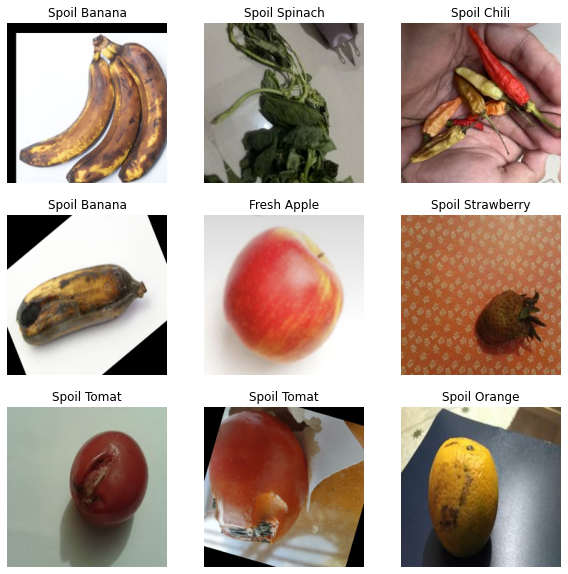

In [24]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

predictions = tf.nn.softmax(predictions)
predictions = list(np.argmax(x) for x in predictions.numpy())

print('Predictions:\n', predictions)
print('Labels:\n', list(np.argmax(x) for x in label_batch))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

#Confusion matrix

In [25]:
print(len(test_dataset))

87


In [27]:
y_pred = np.array([])
y_true =  np.array([])
for x, y in test_dataset:
  y_pred = np.concatenate([y_pred, np.argmax(model.predict(x), axis = -1)])
  y_true = np.concatenate([y_true, np.argmax(y.numpy(), axis=-1)])

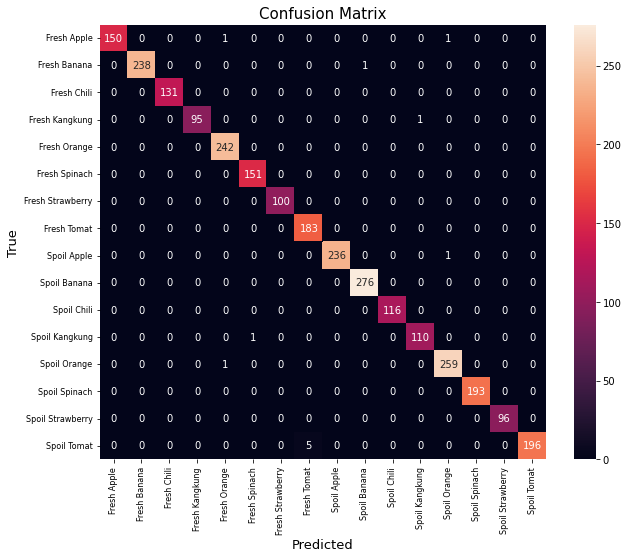

In [29]:
cm = confusion_matrix(y_true, y_pred)

fig = plt.figure(figsize=(10, 8))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells

ax.set_xlabel('Predicted', fontsize=13)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 8)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=13)
ax.yaxis.set_ticklabels(class_names, fontsize = 8)
plt.yticks(rotation=0)

plt.title('Confusion Matrix', fontsize=15)

plt.savefig('ConMat.png')
plt.show()

#Try Model With Custom Single Image

In [35]:
img = image.load_img(path='/content/1313.jpg', target_size=(224,224))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
result = model.predict(img)
print(np.round_(result*100, decimals=2))

y_pred = np.argmax(result, axis=1)
print(y_pred)
if y_pred[0] == 0:
    print("Fresh Apple")
elif y_pred[0] == 1:
    print("Fresh Banana")
elif y_pred[0] == 2:
    print("Fresh Chilli")
elif y_pred[0] == 3:
    print("Fresh Kangkung")
elif y_pred[0] == 4:
    print("Fresh Orange")
elif y_pred[0] == 5:
    print("Fresh Spinach")
elif y_pred[0] == 6:
    print("Fresh Strawberry")
elif y_pred[0] == 7:
    print("Fresh Tomato")
elif y_pred[0] == 8:
    print("Spoil Apple")
elif y_pred[0] == 9:
    print("Spoil Banana")
elif y_pred[0] == 10:
    print("Spoil Chili")
elif y_pred[0] == 11:
    print("Spoil Kangkung")
elif y_pred[0] == 12:
    print("Spoil Orange")
elif y_pred[0] == 13:
    print("Spoil Spinach")
elif y_pred[0] == 14:
    print("Spoil Strawberry")
elif y_pred[0] == 15:
    print("Spoil Tomato")

[[  0.   0.   0. 100.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]]
[3]
Fresh Kangkung


#Save Model

In [36]:
model.save('/content/Model_16_Class_Acc99.h5')